## 3.6 PyTorch中定义网络的方式

In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.utils.data as Data
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 3.6.1 数据准备

boston_X.shape: (506, 13)


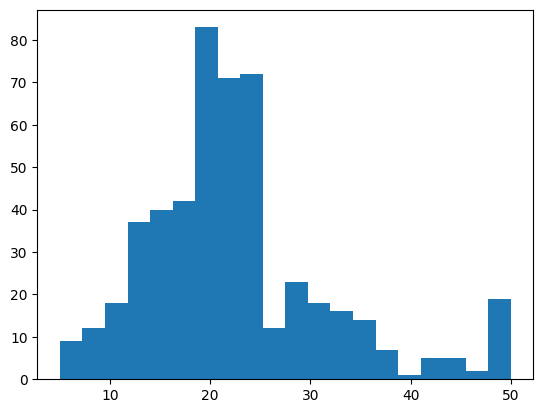

In [3]:
# 读取数据
boston_X, boston_y = load_boston(return_X_y=True)
print("boston_X.shape:", boston_X.shape)
plt.figure()
plt.hist(boston_y, bins=20)
plt.show()

In [14]:
# 数据标准化处理
ss = StandardScaler(with_mean=True, with_std=True)
boston_Xs = ss.fit_transform(boston_X)
# 将数据预处理为可以使用PyTorch进行批量训练的形式
# 训练集X转化为张量
train_xt = torch.from_numpy(boston_Xs.astype(np.float32))
# 训练集y转化为张量
train_yt = torch.from_numpy(boston_y.astype(np.float32))
# 将训练集转化为张量后，使用TensorDataset将X和Y整理到一起
train_data = Data.TensorDataset(train_xt, train_yt)
# 定义一个数据加载器，将训练数据集进行批量处理
train_loader = Data.DataLoader(
    dataset = train_data, # 使用的数据集
    batch_size = 128, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 1 # 使用1个进程
)

(506, 13)

### 3.6.2 使用继承Module的方式定义网络

In [24]:
# 使用集成Module的方式定义全连接神经网络
class MLPmodel(nn.Module):
    def __init__(self):
        super(MLPmodel, self).__init__()
        # 定义第一个隐藏层
        self.hidden1 = nn.Linear(
            in_features = 13, # 第一个隐藏层的输入，数据的特征数
            out_features = 10, # 第一个隐藏层的输出，神经元的数量
            bias = True # 默认会有偏置
        )
        self.active1 = nn.ReLU()
        # 定义第一个隐藏层
        self.hidden2 = nn.Linear(10, 10)
        self.active2 = nn.ReLU()
        # 定义预测回归层
        self.regression = nn.Linear(10, 1)
    # 定义网络的前向传播路径
    def forward(self, x):
        x = self.hidden1(x)
        x = self.active1(x)
        x = self.hidden2(x)
        x = self.active2(x)
        output = self.regression(x)
        # 输出为output
        return output

> 上面的程序定义了一个类MLPmodel，在继承了nn.Module类的基础上对其功能进行了定义<p> 在我们定义的类确定的函数中，包含两个部分，一部分定义了网络结构，另一部分定义了网络结构的向前传播过程forward()函数

In [25]:
# 输出网络结构
mlp1 = MLPmodel()
print(mlp1)

MLPmodel(
  (hidden1): Linear(in_features=13, out_features=10, bias=True)
  (active1): ReLU()
  (hidden2): Linear(in_features=10, out_features=10, bias=True)
  (active2): ReLU()
  (regression): Linear(in_features=10, out_features=1, bias=True)
)


In [26]:
# 对回归模型mlp1进行训练并输出损失函数的变化情况，定义优化器和损失函数
optimizer = SGD(mlp1.parameters(), lr=0.001)
loss_func = nn.MSELoss() # 最小均方根误差
train_loss_all = [] # 输出每个批次训练的损失函数
# 进行训练，并输出每次迭代的损失函数
for epoch in range(30):
    # 对训练数据的加载器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):
        output = mlp1(b_x).flatten() # MLP在训练batch上的输出
        train_loss = loss_func(output, b_y) # 均方根误差
        optimizer.zero_grad() # 每个迭代步的梯度初始化为0
        train_loss.backward() # 损失的后向传播，计算梯度
        optimizer.step() # 使用梯度进行优化
        train_loss_all.append(train_loss.item())

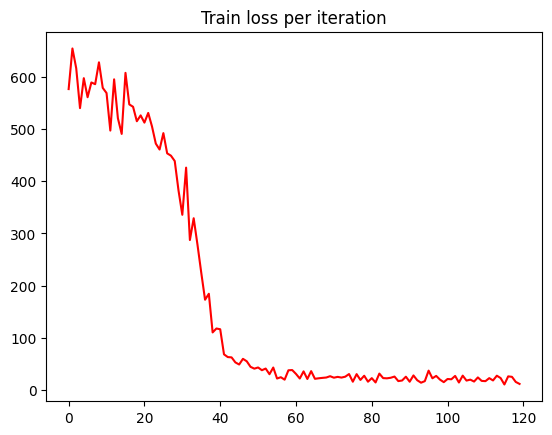

In [27]:
# 将train_loss_all进行可视化
plt.figure()
plt.plot(train_loss_all, "r-")
plt.title("Train loss per iteration")
plt.show()

### 3.6.3 使用nn.Sequential方式定义网络

In [28]:
# 使用定义网络时使用nn.Sequential的形式
class MLPmodel2(nn.Module):
    def __init__(self):
        super(MLPmodel2, self).__init__()
        # 定义隐藏层
        self.hidden = nn.Sequential(
            nn.Linear(13, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU()
        )
        # 预测回归层
        self.regression = nn.Linear(10, 1)
    # 定义网络的前向传播路径
    def forward(self, x):
        x = self.hidden(x)
        output = self.regression(x)
        return output

> 由于nn.Sequential()函数的使用，上面的程序定义网络的结构和向前传播函数得到了简化，网络中通过nn.Sequential()函数将两个nn.Linear()层和两个nn.ReLU()层统一打包为self.hidden层，所以向前传播过程函数得到了简化

In [29]:
# 输出网络结构
mlp2 = MLPmodel2()
print(mlp2)

MLPmodel2(
  (hidden): Sequential(
    (0): Linear(in_features=13, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
  (regression): Linear(in_features=10, out_features=1, bias=True)
)


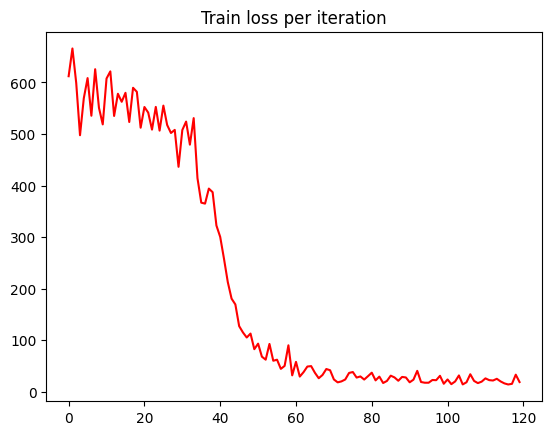

In [30]:
# 对回归模型mlp2进行训练并输出损失函数的变化情况，定义优化器和损失函数
optimizer = SGD(mlp2.parameters(), lr=0.001)
loss_func = nn.MSELoss() # 最小均方根误差
train_loss_all = [] # 输出每个批次训练的损失函数
# 进行训练，并输出每次迭代的损失函数
for epoch in range(30):
    # 对训练数据的加载器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):
        output = mlp2(b_x).flatten() # mlp在训练batch上的输出
        train_loss = loss_func(output, b_y) # 均方根误差
        optimizer.zero_grad() # 每个迭代步的梯度初始化为0
        train_loss.backward() # 损失的后向传播，计算梯度
        optimizer.step() # 使用梯度进行优化
        train_loss_all.append(train_loss.item())
plt.figure()
plt.plot(train_loss_all, "r-")
plt.title("Train loss per iteration")
plt.show()

## 3.7 模型的保存与加载

#### 1.保存整个模型

In [31]:
# 保存整个模型
torch.save(mlp2, "C:/Users/xinx_/Desktop/mlp2.pkl")

In [32]:
# 导入保存的模型
mlp2load = torch.load("C:/Users/xinx_/Desktop/mlp2.pkl")
mlp2load

MLPmodel2(
  (hidden): Sequential(
    (0): Linear(in_features=13, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
  (regression): Linear(in_features=10, out_features=1, bias=True)
)

#### 2.只保存模型的参数

In [33]:
torch.save(mlp2.state_dict(), "C:/Users/xinx_/Desktop/mlp2_param.pkl")
# 导入保存的模型的参数
mlp2param = torch.load("C:/Users/xinx_/Desktop/mlp2_param.pkl")
mlp2param

OrderedDict([('hidden.0.weight',
              tensor([[-0.3370,  0.0108,  0.0152,  0.1534,  0.2213, -0.2969,  0.4002, -0.3213,
                        0.3612,  0.4727,  0.1402, -0.0244, -0.4499],
                      [-0.2633, -0.0167, -0.0060, -0.3195,  0.1023, -0.0090, -0.1548, -0.0778,
                       -0.3395, -0.3056, -0.2366,  0.3220,  0.0808],
                      [ 0.1213,  0.1206, -0.0708, -0.1993,  0.2124,  0.0657, -0.1326,  0.1172,
                        0.1638, -0.0633,  0.0762, -0.0727, -0.2040],
                      [ 0.0790,  0.0949, -0.2093, -0.1082, -0.0662, -0.1545,  0.1627, -0.0047,
                       -0.0656,  0.1675, -0.0751, -0.0418, -0.0167],
                      [-0.3064,  0.1754, -0.0917, -0.2901,  0.0967,  0.5887,  0.0044, -0.0677,
                        0.3128,  0.1072, -0.2384,  0.3916, -0.3920],
                      [-0.4886, -0.0458, -0.0464,  0.3462, -0.2992,  0.5578,  0.0153, -0.2834,
                       -0.1945, -0.4028, -0.1754,  0